# Fig. 11

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import xarray as xr 
import seaborn as sns
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 20})

import warnings
warnings.filterwarnings("ignore")

## Funtions 

In [2]:
def another_mask(ds, cutoff, dlat=0.3, dlon=0.5, use_tracer=True):
    """
    Applies a mask to the dataset based on latitude, longitude, and a threshold quantile height.

    Parameters:
    ds (xarray.Dataset): The dataset to be masked.
    cutoff (float): The threshold factor for determining the mask.
    dlat (float): The latitude range around -36° for the mask (default is 0.3).
    dlon (float): The longitude range around 146.5° for the mask (default is 0.5).
    use_tracer (bool): If True, use the "Qpassive_1" tracer for calculation; otherwise, use density (default is True).

    Returns:
    xarray.Dataset: The dataset with an additional 'ao_mask' variable.
    """
    # Apply the initial geographical mask based on latitude and longitude
    ds_masked = ds.where(
        (ds.lat >= -36 - dlat) & (ds.lat <= -36 + dlat) & 
        (ds.lon >= 146.5 - dlon) & (ds.lon <= 146.5 + dlon),
        other=np.nan
    )

    # Apply the mask based on quantile height (5th percentile)
    ds_masked2 = ds_masked.where(
        ds.height > quantile_height(ds, quantile=0.05),
        other=np.nan
    )

    # Calculate flux based on the tracer or density
    if use_tracer:
        qflux = ds_masked2["w_intp"] * ds_masked2["Qpassive_1"]
    else:
        qflux = ds_masked2["w_intp"] * dens(ds_masked2)

    # Determine the maximum flux and apply the cutoff factor
    qmax = qflux.max(("lon", "lat"))
    threshold = qmax * cutoff
    aomask = qflux > threshold

    # Assign the mask to the dataset
    ds['ao_mask'] = (("time", "height", "lat", "lon"), aomask.data)

    return ds

def quantile_height(ds, var="Qpassive_1", quantile=0.05):
    """
    Calculates the height above which a specified quantile percentage of the given variable are located.
    Primarily used with 'Qpassive_1' to determine the injection height.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable of interest.
    var (str): The variable name to use for calculation (default is "Qpassive_1").
    quantile (float): The quantile value (e.g., 0.05 for 5%) to determine the height threshold (default is 0.05).

    Returns:
    xarray.DataArray: The minimum height where the specified quantile condition is met.
    """
    
    ds = ds.mean(("lat", "lon"))
    rho = dens(ds)
    dz = -1 * z.differentiate("height")
    qplume = ds[var] * rho.values * dz.values
    qplume_sum = qplume.cumsum(dim="height")
    qplume_100 = qplume_sum.max(dim="height")
    qplume_q = qplume_100 * quantile
    height_q = ds['height'].where(qplume_q < qplume_sum)
    height_q_min = height_q.min(dim="height")

    return height_q_min


def dens(d): 
    R = 287.1
    densitiy = d.pres / (R * d.temp)
    return densitiy



def cloud_base(dset):
    """
    Finds the cloud base height where the 'qc' variable exceeds a certain threshold.

    Parameters:
    dset (xarray.Dataset): The dataset containing the 'qc' variable and a mask called 'inner_mask'.

    Returns:
    xarray.DataArray: The height at which 'qc' exceeds the threshold.
    """
    # Apply the mask to the dataset
    dset = dset.where(dset.ao_mask, np.nan)

    # Calculate the mean across the 'lon' and 'lat' dimensions
    data = dset.mean(("lon", "lat"))

    # Find 'qc' values that exceed the threshold (0.0002)
    qc_above_threshold = data['qc'].where(data['qc'] > 0.0002).values

    # Find the indices where 'qc' is not NaN
    valid_indices = np.where(~np.isnan(qc_above_threshold))

    # Find the highest valid index for the cloud base
    if valid_indices[0].size > 0:  # Ensure there is a valid index
        highest_index = np.max(valid_indices)
        highest_height = dset.height.isel(height=highest_index)
    else:
        highest_height = np.nan  # Return NaN if no valid index is found

    return highest_height



def more_vars(ds):
    """
    Calculates additional thermodynamic variables and adds them to the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing temperature and water vapor data.

    Returns:
    xarray.Dataset: The original dataset with additional variables for analysis.
    """
    # Constants for calculations
    p0 = 1000  # Reference pressure in hPa
    lv_const_a = 2500.78  # Latent heat constant (a)
    lv_const_b = 2.32573  # Latent heat constant (b)
    Rd = 287.04  # Specific gas constant for dry air (J/(kg·K))
    cp = 1004.82  # Specific heat capacity at constant pressure (J/(kg·K))
    cw = 4186.74  # Specific heat capacity of water (J/(kg·K))

    # Calculate the mixing ratio of water vapor
    r = ds.qv / (1 - ds.qv)

    # Calculate the latent heat of vaporization (lv)
    lv = lv_const_a - (ds.temp * lv_const_b)

    # Calculate equivalent potential temperature (theta_ae)
    theta_ae = (ds.temp + r * (lv / (cp + r * cw))) * ((p0 / ds.height) ** (Rd / cp))
    ds["theta_ae"] = theta_ae

    # Calculate potential temperature (tpot)
    tpot = ds.temp * ((p0 / ds.height) ** (Rd / cp))
    ds["tpot"] = tpot

    # Add the mixing ratio as a variable to the dataset
    ds["r"] = r

    # Calculate and add density to the dataset
    ds["dens"] = dens(ds)

    # Calculate total water content and condensed water content
    ds["qtotal"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr + ds.qv
    ds["qcondens"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr

    return ds



## Get Data

In [3]:
data_path = "../data/"
dsref = xr.open_mfdataset(data_path + "exp_ref.nc", engine = 'netcdf4').isel(time = slice(2,None)).mean("time").squeeze()
dsref = more_vars(dsref)

z = xr.open_mfdataset("./height_info.nc").mean("time").squeeze().mean(("lat", "lon"))["z_mc"]
z = z.assign_coords(height=dsref.height)

In [4]:
cut = 0.05

ds25 = xr.open_mfdataset(data_path + "exp_025.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds26 = xr.open_mfdataset(data_path + "exp_026.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds27 = xr.open_mfdataset(data_path + "exp_027.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds28 = xr.open_mfdataset(data_path + "exp_028.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
dsets = [ds25, ds26, ds27, ds28]

for ds in dsets:
    ds = more_vars(ds)
    ds = another_mask(ds, cut)

## Prepare Plot

In [5]:
# Function to print Cloud Bases
def printcb(ds, t = 1):
    v = (cloud_base(ds.mean("time")).values)
    print(v)
    return(v)

In [6]:
# Define reference profile
ref_profile = dsref.mean(("lon", "lat"))

In [7]:
# Adjust Colormaps 

## For the Reference
from matplotlib.colors import LinearSegmentedColormap
cmap = plt.get_cmap('Greys')
greys = LinearSegmentedColormap.from_list('truncated_viridis', cmap(np.linspace(0.2, 1, 100)))

## For the Actual Data
colormap2 = plt.cm.plasma
scolors = [colormap2(i / 4) for i in range(4)]

In [24]:
# Set some values for the plot
top = 500
var = "theta_ae"
var2 = "qv"
xmin, xmax = 300, 450
ymin, ymax = 4, 25
my_dsets = [ds25, ds26, ds27, ds28]
labels = ["30% LH Flux", "20% LH Flux", "10% LH Flux", "0% LH Flux"]
marker_style = ["o", "X","d", "*" ]
marker_size = [60,70,70,90]

## Plot Figure


604.1874
594.47754
584.7658
575.0565


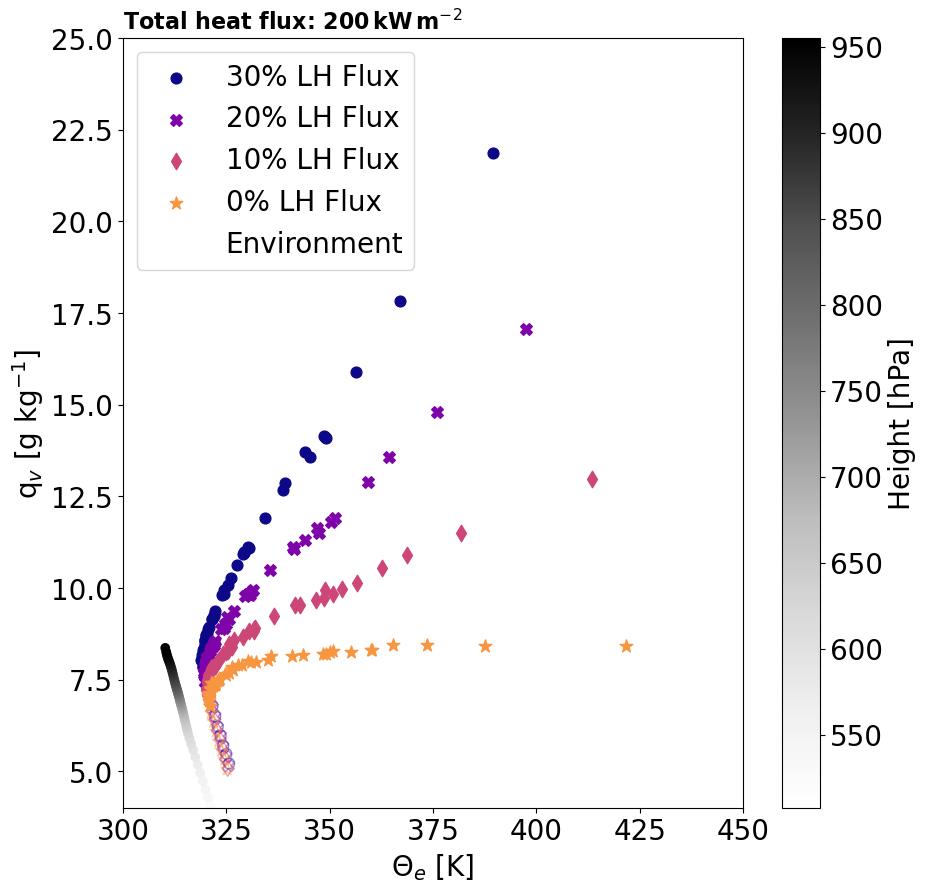

In [25]:
# Plot data for each dataset
for n, (ds, label) in enumerate(zip(my_dsets, labels)):
    hcut = printcb(ds)

    # First slice (hcut to 1000)
    ds_slice = ds.where(ds.ao_mask, np.nan).sel(height=slice(hcut, 1000)).mean("time")
    plt.scatter(
        ds_slice[var].mean(("lon", "lat")),
        1000 * ds_slice[var2].mean(("lon", "lat")),
        color=scolors[n],
        s = marker_size[n],
        marker = marker_style[n],
        label=label
    )

    # Second slice (top to hcut)
    ds_slice = ds.where(ds.ao_mask, np.nan).sel(height=slice(top, hcut)).mean("time")
    plt.scatter(
        ds_slice[var].mean(("lon", "lat")),
        1000 * ds_slice[var2].mean(("lon", "lat")),
        facecolors='none',
        edgecolors=scolors[n],
        s = marker_size[n],
        alpha=0.5,
        marker = marker_style[n]
        
    )

# Reference profile
hcut = top
ds_ref = ref_profile.sel(height=slice(hcut, 1000))
plt.scatter(
    ds_ref[var],
    1000 * ds_ref[var2],
    c=ref_profile.height.sel(height=slice(hcut, 1000)),
    cmap="Greys",
    label="Environment"
)
plt.colorbar(label="Height [hPa]")

# Customize plot
plt.legend(loc="upper left")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel(rf"$\Theta_{{e}}$ [K]")
plt.ylabel(rf"q$_{{v}}$ [g kg$^{{-1}}$]")
plt.title(rf"Total heat flux: 200$\,$kW$\,$m$^{{-2}}$", fontweight="bold", loc="left", fontsize=16)

# Save the figure
my_path = "./figs/"
plt.savefig(my_path + 'fig11.png', dpi=300, bbox_inches='tight')
plt.savefig(my_path + 'fig11_lq.png', dpi=50, bbox_inches='tight')
